In [271]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
df = pd.read_csv('data/data_clean.csv')
df['zipcode'] = df['zipcode'].astype('str')
def model_diag(results):
    mae = int(round(results.resid.abs().sum() / len(y),0))
    print(f'MAE:{mae}')
    fig, ax = plt.subplots(1,3,figsize=(20,5))
    sns.scatterplot(x= df['sqft_living_norm'],y= results.resid, ax=ax[0])
    sns.histplot(results.resid, bins=20, element="step", kde=True, ax=ax[1])
    sm.graphics.qqplot(results.resid, dist=stats.norm, line='45', fit=True, ax=ax[2])
    plt.show();
    print(results.summary())
def result_df(results):
    """
    This function takes a results object and creates a dataframe with a single row
    including adjusted R-squared, Mean Absolute Error, the number of p-values greater
    than 0.05 from the coefficients, and Conditional Number. 
    """
    res_dic = {}
    res_dic['features'] = len(results.params)
    res_dic['r2_adj'] = round(results.rsquared_adj * 100, 2)
    res_dic['MAE'] = round(results.resid.abs().sum() / len(y),0)
    res_dic['large_pvals'] = (results.pvalues.apply(lambda x: round(x, 2))
                              > 0.05).sum()
    res_dic['cond_num'] = results.condition_number
    pvals = results.pvalues.apply(lambda x: round(x, 2))
    large_pvals = list(pvals[pvals > 0.05].index)
    if len(large_pvals) == 0:
        print(abs(results.params).sort_values())
    else:
        print(f'Large_pvals: {list(pvals[pvals>0.05].index)}')
    return pd.DataFrame(res_dic, index=[0])
def RFE_df(df,
           features=[
               'sqft_living_norm', 'bathrooms_norm', 'bedrooms_norm',
               'view_norm', 'sqft_basement_norm', 'floors_norm', 'greenbelt',
               'waterfront', 'zipcode'
           ],
           to_drop=['zipcode_98059'],
           start=0,
           stop=10):
    """
    This function goes runs MLR models and removes the any p-values larger
    than 0.05. If there are none, it removes the feature with the smallest 
    absolute coefficient. It then adds a row and creates a dataframe with 
    relevent metrics. 
    """
    res_df = pd.DataFrame({})
    dropped = None
    while start < stop:
        y = df['price']
        X = pd.get_dummies(df[features]).drop(columns=to_drop)
        model = sm.OLS(y, sm.add_constant(X))
        results = model.fit()
        res_dic = {}
        num_features = len(results.params)
        res_dic['num_features'] = num_features
        res_dic['r2_adj'] = round(results.rsquared_adj * 100, 2)
        res_dic['f_pvalue'] = results.f_pvalue
        res_dic['MAE'] = round(results.resid.abs().sum() / len(y), 0)
        res_dic['large_pvals'] = (results.pvalues.apply(lambda x: round(x, 2))
                                  > 0.01).sum()
        res_dic['cond_num'] = results.condition_number
        res_dic['dropped'] = dropped
        pvals = results.pvalues.apply(lambda x: round(x, 3))
        large_pvals = list(pvals[pvals > 0.05].index)
        
        if len(large_pvals) == 0:
            feat = results.params.abs().sort_values().index[0]
#             if (feat == 'const') or (feat == 'sqft_living_norm'):
#                 feat = results.params.abs().sort_values().index[1]
#                 if (feat == 'const') or (feat == 'sqft_living_norm'):
#                     dropped = results.params.abs().sort_values().index[2]
#                 else:
#                     dropped = results.params.abs().sort_values().index[1]
            if feat == 'const':
                dropped = results.params.abs().sort_values().index[1]
            else:
                dropped = results.params.abs().sort_values().index[0] 
            to_drop.append(dropped)
        elif len(large_pvals) > 1:
            dropped = ""
            for i in large_pvals[:-1]:
                dropped += i + ', '
            dropped += test[-1]
            for i in large_pvals:
                to_drop.append(i)
        else:
            dropped = large_pvals[0]
            to_drop.append(dropped)
        start += 1
        res_df = res_df.append(pd.DataFrame(res_dic, index=[0]),
                               ignore_index=True)
#     print(f'Dropped: {dropped}')
#     print(f'Drop List: {to_drop}')
    return res_df,to_drop,results

# Using my RFE Function

In [274]:
dfn,drop_list,results = RFE_df(df,
           features=[
               'sqft_living_norm', 'bathrooms_norm', 'bedrooms_norm',
               'view_norm', 'sqft_basement_norm', 'floors_norm', 'greenbelt',
               'waterfront', 'zipcode'
           ],
           to_drop=['zipcode_98059'],
           start=0,
           stop=10)

In [275]:
dfn

,num_features,r2_adj,f_pvalue,MAE,large_pvals,cond_num,dropped
0,83,73.56,0.0,191127.0,6,99.140318,None
1,77,73.55,0.0,191137.0,0,71.978462,"zipcode_98019, zipcode_98045, zipcode_98106, z..."
2,76,73.51,0.0,191288.0,0,64.787270,bedrooms_norm
3,75,73.46,0.0,192002.0,0,62.079918,floors_norm
4,74,73.42,0.0,192066.0,0,57.971083,bathrooms_norm
5,73,72.93,0.0,193310.0,1,51.675064,sqft_basement_norm
6,72,72.93,0.0,193307.0,1,51.659843,zipcode_98014
7,71,72.02,0.0,196694.0,1,47.072807,view_norm
8,70,72.02,0.0,196692.0,0,47.059212,zipcode_98070
9,69,72.00,0.0,196775.0,0,47.041820,greenbelt


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.720
Model:                            OLS   Adj. R-squared:                  0.720
Method:                 Least Squares   F-statistic:                     1824.
Date:                Tue, 20 Jun 2023   Prob (F-statistic):               0.00
Time:                        19:22:01   Log-Likelihood:            -6.6570e+05
No. Observations:               47579   AIC:                         1.332e+06
Df Residuals:                   47511   BIC:                         1.332e+06
Df Model:                          67                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             8.657e+05   3632.723    238.317      0.000    8.59e+05    8.73e+05
sqft_living_norm  2.921e+05   1435.682    203.466      0.000    2.89e+05    2.95e+05
waterfront        4.802e+05   1.27e+04     37.879      0.000    4.55e+05    5.05e+05
zipcode_98001    -2.614e+05   1.01e+04    -25.851      0.000   -2.81e+05   -2.42e+05
zipcode_98002    -2.227e+05   1.23e+04    -18.141      0.000   -2.47e+05   -1.99e+05
zipcode_98003    -2.227e+05   1.09e+04    -20.394      0.000   -2.44e+05   -2.01e+05
zipcode_98004      1.17e+06   1.68e+04     69.762      0.000    1.14e+06     1.2e+06
zipcode_98005     7.668e+05   1.86e+04     41.147      0.000     7.3e+05    8.03e+05
zipcode_98006     5.605e+05   1.03e+04     54.253      0.000     5.4e+05    5.81e+05
zipcode_98007     4.583e+05   1.85e+04     24.800      0.000    4.22e+05    4.95e+05
zipcode_98008     5.198e+05   1.17e+04     44.257      0.000    4.97e+05    5.43e+05
zipcode_98010    -2.567e+05   1.53e+04    -16.758      0.000   -2.87e+05   -2.27e+05
zipcode_98011     1.865e+05   1.36e+04     13.767      0.000     1.6e+05    2.13e+05
zipcode_98022    -2.371e+05   1.31e+04    -18.146      0.000   -2.63e+05   -2.11e+05
zipcode_98023    -2.592e+05   8996.111    -28.813      0.000   -2.77e+05   -2.42e+05
zipcode_98024     1.034e+05   2.88e+04      3.588      0.000    4.69e+04     1.6e+05
zipcode_98027     2.794e+05   1.34e+04     20.854      0.000    2.53e+05    3.06e+05
zipcode_98028      1.08e+05   1.24e+04      8.692      0.000    8.36e+04    1.32e+05
zipcode_98029     3.883e+05   1.35e+04     28.662      0.000    3.62e+05    4.15e+05
zipcode_98030    -2.238e+05   1.23e+04    -18.162      0.000   -2.48e+05      -2e+05
zipcode_98031    -2.011e+05   1.08e+04    -18.695      0.000   -2.22e+05    -1.8e+05
zipcode_98032    -2.043e+05   1.69e+04    -12.106      0.000   -2.37e+05   -1.71e+05
zipcode_98033     8.179e+05   1.01e+04     80.708      0.000    7.98e+05    8.38e+05
zipcode_98034     2.939e+05   9191.587     31.972      0.000    2.76e+05    3.12e+05
zipcode_98038    -1.654e+05   8981.022    -18.420      0.000   -1.83e+05   -1.48e+05
zipcode_98039     1.712e+06    5.2e+04     32.926      0.000    1.61e+06    1.81e+06
zipcode_98040     9.207e+05   1.36e+04     67.472      0.000    8.94e+05    9.47e+05
zipcode_98042    -2.299e+05   8259.211    -27.831      0.000   -2.46e+05   -2.14e+05
zipcode_98047     -2.08e+05   2.48e+04     -8.399      0.000   -2.57e+05   -1.59e+05
zipcode_98051    -1.724e+05   6.17e+04     -2.795      0.005   -2.93e+05   -5.15e+04
zipcode_98052     4.968e+05   9795.045     50.724      0.000    4.78e+05    5.16e+05
zipcode_98053      3.26e+05   1.35e+04     24.117      0.000       3e+05    3.53e+05
zipcode_98055    -1.688e+05   1.56e+04    -10.793      0.000   -1.99e+05   -1.38e+05
zipcode_98056     6.051

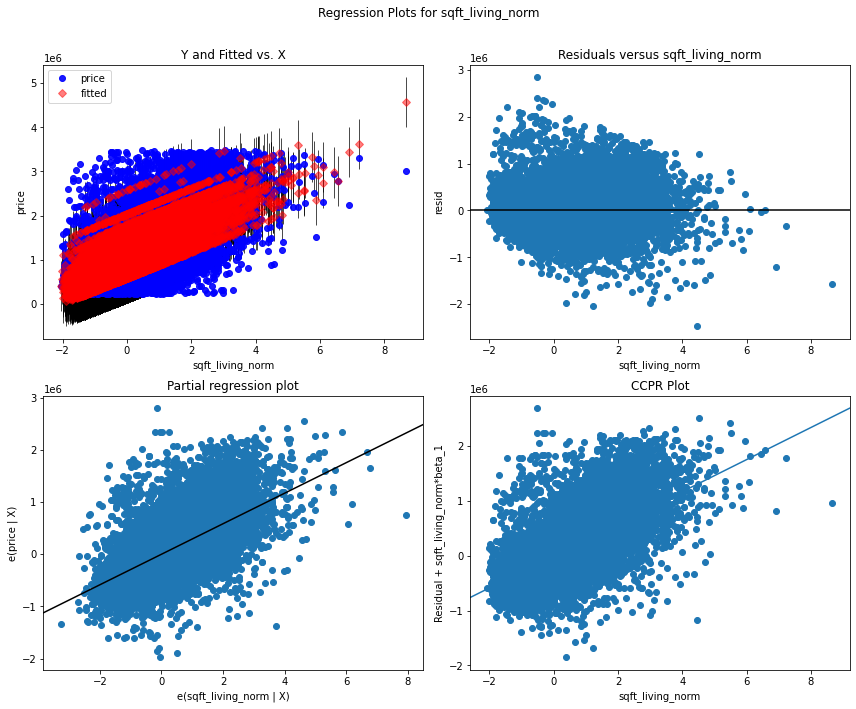

In [277]:
fig = plt.figure(figsize=(12,10))
sm.graphics.plot_regress_exog(results, "sqft_living_norm", fig=fig)
plt.show()

In [4]:
price_by_zips = df.groupby('zipcode').mean()['price'].sort_values()
med_price = price_by_zips.median()
price_by_zips[price_by_zips==med_price]

zipcode
98059    956976.711087
Name: price, dtype: float64

# Baseline

In [284]:
# Since sqft_living is the feature with the strongest correlation, let's build a simple linear regression with that.
y = df['price']
X = df['sqft_living']
model = sm.OLS(y, sm.add_constant(X))
baseline_results = model.fit()
baseline_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.420
Model:                            OLS   Adj. R-squared:                  0.420
Method:                 Least Squares   F-statistic:                 3.452e+04
Date:                Tue, 20 Jun 2023   Prob (F-statistic):               0.00
Time:                        20:48:26   Log-Likelihood:            -6.8301e+05
No. Observations:               47579   AIC:                         1.366e+06
Df Residuals:                   47577   BIC:                         1.366e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1.457e+05   5024.446     28.998      0.000    1.36e+05    1.56e+05
sqft_living   422.8334      2.276    185.792      0.000     418.373     427.294
==============================================================================
Omnibus:                     9411.902   Durbin-Watson:                   0.932
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            27262.552
Skew:                           1.042   Prob(JB):                         0.00
Kurtosis:                       6.067   Cond. No.                     5.83e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.83e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Final Model

In [285]:
features = ['sqft_living_norm', 'waterfront', 'zipcode']
y = df['price']
X = pd.get_dummies(df[features]).drop(columns=[
    'zipcode_98059', 'zipcode_98019', 'zipcode_98045', 'zipcode_98106',
    'zipcode_98108', 'zipcode_98146', 'zipcode_98166', 'zipcode_98014',
    'zipcode_98070', 'zipcode_98133'
])
model = sm.OLS(y, sm.add_constant(X))
final_results = model.fit()
final_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.720
Model:                            OLS   Adj. R-squared:                  0.720
Method:                 Least Squares   F-statistic:                     1824.
Date:                Tue, 20 Jun 2023   Prob (F-statistic):               0.00
Time:                        20:49:28   Log-Likelihood:            -6.6570e+05
No. Observations:               47579   AIC:                         1.332e+06
Df Residuals:                   47511   BIC:                         1.332e+06
Df Model:                          67                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             8.657e+05   3632.723    238.317      0.000    8.59e+05    8.73e+05
sqft_living_norm  2.921e+05   1435.682    203.466      0.000    2.89e+05    2.95e+05
waterfront        4.802e+05   1.27e+04     37.879      0.000    4.55e+05    5.05e+05
zipcode_98001    -2.614e+05   1.01e+04    -25.851      0.000   -2.81e+05   -2.42e+05
zipcode_98002    -2.227e+05   1.23e+04    -18.141      0.000   -2.47e+05   -1.99e+05
zipcode_98003    -2.227e+05   1.09e+04    -20.394      0.000   -2.44e+05   -2.01e+05
zipcode_98004      1.17e+06   1.68e+04     69.762      0.000    1.14e+06     1.2e+06
zipcode_98005     7.668e+05   1.86e+04     41.147      0.000     7.3e+05    8.03e+05
zipcode_98006     5.605e+05   1.03e+04     54.253      0.000     5.4e+05    5.81e+05
zipcode_98007     4.583e+05   1.85e+04     24.800      0.000    4.22e+05    4.95e+05
zipcode_98008     5.198e+05   1.17e+04     44.257      0.000    4.97e+05    5.43e+05
zipcode_98010    -2.567e+05   1.53e+04    -16.758      0.000   -2.87e+05   -2.27e+05
zipcode_98011     1.865e+05   1.36e+04     13.767      0.000     1.6e+05    2.13e+05
zipcode_98022    -2.371e+05   1.31e+04    -18.146      0.000   -2.63e+05   -2.11e+05
zipcode_98023    -2.592e+05   8996.111    -28.813      0.000   -2.77e+05   -2.42e+05
zipcode_98024     1.034e+05   2.88e+04      3.588      0.000    4.69e+04     1.6e+05
zipcode_98027     2.794e+05   1.34e+04     20.854      0.000    2.53e+05    3.06e+05
zipcode_98028      1.08e+05   1.24e+04      8.692      0.000    8.36e+04    1.32e+05
zipcode_98029     3.883e+05   1.35e+04     28.662      0.000    3.62e+05    4.15e+05
zipcode_98030    -2.238e+05   1.23e+04    -18.162      0.000   -2.48e+05      -2e+05
zipcode_98031    -2.011e+05   1.08e+04    -18.695      0.000   -2.22e+05    -1.8e+05
zipcode_98032    -2.043e+05   1.69e+04    -12.106      0.000   -2.37e+05   -1.71e+05
zipcode_98033     8.179e+05   1.01e+04     80.708      0.000    7.98e+05    8.38e+05
zipcode_98034     2.939e+05   9191.587     31.972      0.000    2.76e+05    3.12e+05
zipcode_98038    -1.654e+05   8981.022    -18.420      0.000   -1.83e+05   -1.48e+05
zipcode_98039     1.712e+06    5.2e+04     32.926      0.000    1.61e+06    1.81e+06
zipcode_98040     9.207e+05   1.36e+04     67.472      0.000    8.94e+05    9.47e+05
zipcode_98042    -2.299e+05   8259.211    -27.831      0.000   -2.46e+05   -2.14e+05
zipcode_98047     -2.08e+05   2.48e+04     -8.399      0.000   -2.57e+05   -1.59e+05
zipcode_98051    -1.724e+05   6.17e+04     -2.795      0.005   -2.93e+05   -5.15e+04
zipcode_98052     4.968e+05   9795.045     50.724      0.000    4.78e+05    5.16e+05
zipcode_98053      3.26e+05   1.35e+04     24.117      0.000       3e+05    3.53e+05
zipcode_98055    -1.688e+05   1.56e+04    -10.793      0.000   -1.99e+05   -1.38e+05
zipcode_98056     6.051

# Model Evaluation

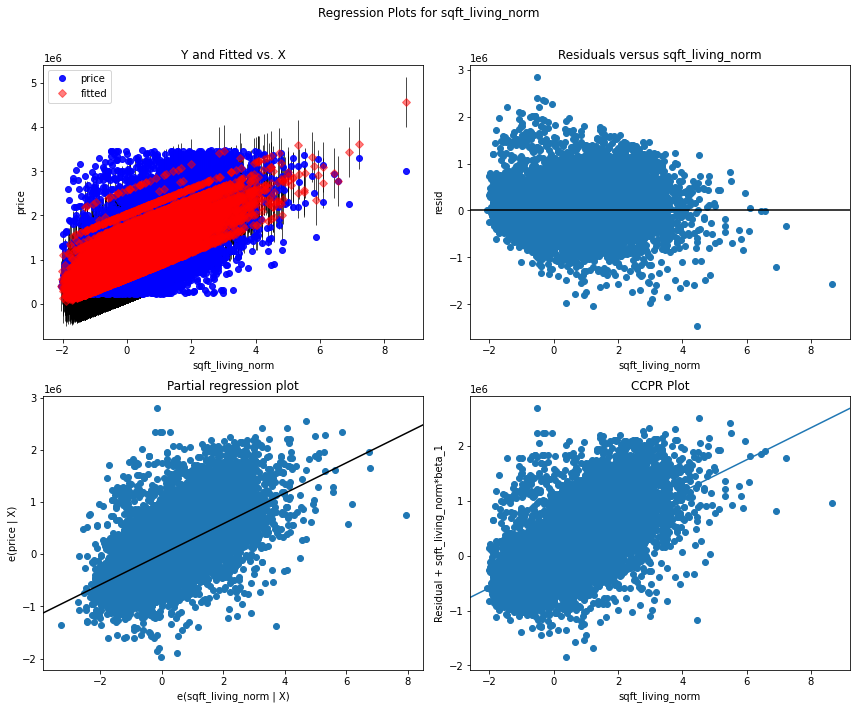

In [286]:
fig = plt.figure(figsize=(12,10))
sm.graphics.plot_regress_exog(final_results, "sqft_living_norm", fig=fig)
plt.show()

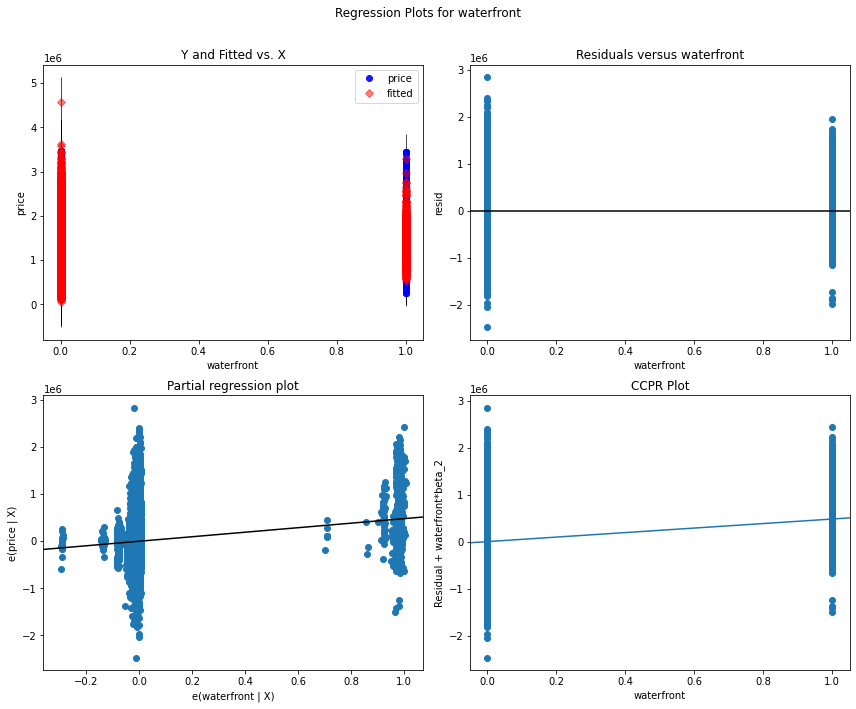

In [287]:
fig = plt.figure(figsize=(12,10))
sm.graphics.plot_regress_exog(final_results, "waterfront", fig=fig)
plt.show()

In [ ]:
plt.style.available

In [ ]:
plt.style.use("seaborn-muted")


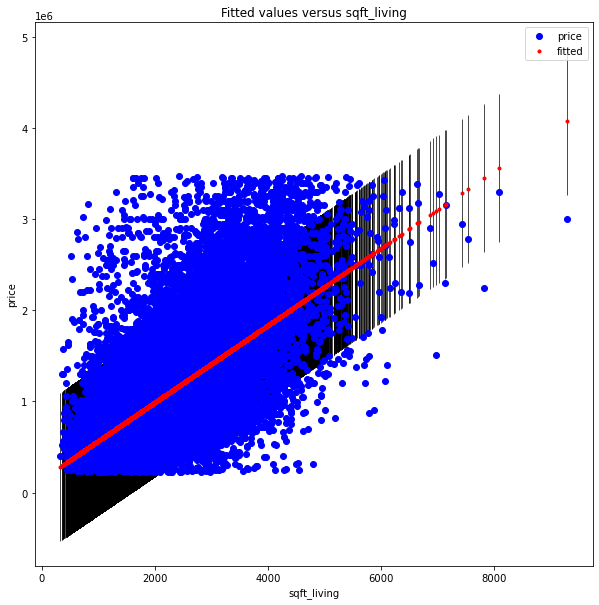

In [219]:
fig,ax = plt.subplots(figsize = (10,10))
ax.scatter
sm.graphics.plot_fit(baseline_results, "sqft_living",ax=ax,marker='.',)
plt.show()

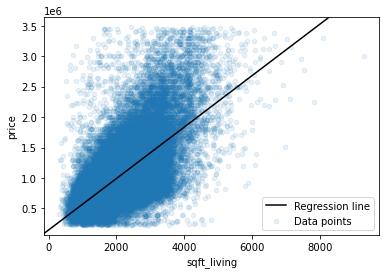

In [220]:
fig, ax = plt.subplots()
df.plot.scatter(x="sqft_living", y="price", label="Data points", ax=ax,alpha=0.1)
sm.graphics.abline_plot(model_results=baseline_results, label="Regression line", ax=ax, color="black")
ax.legend();

In [ ]:
fig, ax = plt.subplots()

ax.scatter(df["price"], baseline_results.resid, alpha=0.2)
ax.axhline(y=0, color="black")
ax.set_xlabel("price")
ax.set_ylabel("residuals");

In [ ]:
sm.graphics.plot_fit(final_results, "sqft_living_norm",marker='.')
plt.show()

In [ ]:
fig = plt.figure(figsize=(12,10))
sm.graphics.plot_regress_exog(final_results, "sqft_living_norm", fig=fig)
plt.show()

In [ ]:
fig = plt.figure(figsize=(12,10))
sm.graphics.plot_regress_exog(baseline_results, "sqft_living", fig=fig)
plt.show()